In [2]:
!pip install duckduckgo_search

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [4]:
from duckduckgo_search import DDGS # pip install duckduckgo_search
from fastdownload import download_url # conda install fastdownload
from fastcore.all import * # conda install -c fastai fastai or conda install pytorch torchvision -c pytorch

from fastai.vision.all import *

from urllib.error import HTTPError

In [5]:
# A function that search images.
def search_images(term, max_images=2):
    print(f"Searching for '{term}'")
    return DDGS().images(keywords=term, max_results=max_images)

Searching for 'bird photos'
[{'title': '1000+ Beautiful Exotic Birds Photos · Pexels · Free Stock Photos', 'image': 'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg', 'thumbnail': 'https://tse3.mm.bing.net/th?id=OIP.3hTkhdPZ8PRL3R6saGGNAgHaE7&pid=Api', 'url': 'https://www.pexels.com/search/exotic+birds/', 'height': 1333, 'width': 2000, 'source': 'Bing'}]


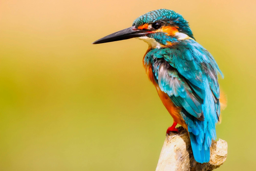

In [6]:
# Search, download and show a picture of a bird.
bird_dest = 'data/bird.jpg'
bird_urls = search_images('bird photos', max_images=1) # Relies on ddg, if error just try again.

print(bird_urls)
download_url(bird_urls[0]['image'], bird_dest, show_progress=True)

im = Image.open(bird_dest)
im.to_thumb(256,256)

Searching for 'forest photos'


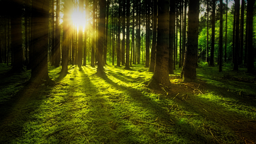

In [7]:
# Search, download and show a picture of a forest.
forest_dest = 'data/forest.jpg'
forest_urls = search_images('forest photos', max_images=1)
download_url(forest_urls[0]['image'], forest_dest, show_progress=True)

im = Image.open(forest_dest)
im.to_thumb(256,256)

In [8]:
searches = 'forest','bird'
path = Path('data/bird_or_not')
from time import sleep

for search in searches:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)

    # This block search and download a version of the searchterm.
    images = search_images(f'{search} photo', max_images=30)
    url_list = []
    for url in images:
        url_list.append(url['image'])   
    download_images(dest, urls=url_list)
    sleep(10)  # Pause between searches to avoid over-loading server

    # This block search and download a version of the searchterm.
    images = search_images(f'{search} sun photo', max_images=30)
    url_list = []
    for url in images:
        url_list.append(url['image'])  
    download_images(dest, urls=url_list)
    sleep(10)  # Pause between searches to avoid over-loading server

    # This block search and download a version of the searchterm.
    images = search_images(f'{search} shade photo', max_images=30)
    url_list = []
    for url in images:
        url_list.append(url['image'])  
    download_images(dest, urls=url_list)

    # Resize all the images in the folder.
    resize_images(path/search, max_size=400, dest=path/search)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


In [9]:
# Removed images that did not download correctly.
path = Path('data/bird_or_not')
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

In [10]:
path = Path('data/bird_or_not')

# Prepare the dataset. Both the training set and the validation set.
dataloaders = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Input is images, Output is categories (bird / forest).
    get_items=get_image_files, # Get image files in path recursively, only in folders, if specified.
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Create function that splits items between train/val with valid_pct randomly.
    get_y=parent_label, # Label item with the parent folder name.
    item_tfms=[Resize(192, method='squish')] # Resize image by squishing (not cropping) before training.
).dataloaders(path, bs=32, verbose=True) # https://docs.fast.ai/data.block.html#datablock.dataloaders

Found 567 items
2 datasets of sizes 454,113
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize -- {'size': (192, 192), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}


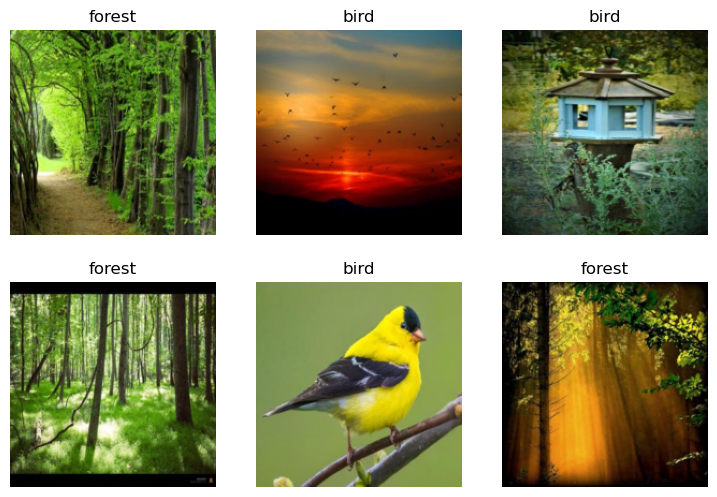

In [11]:
dataloaders.show_batch(max_n=6)

In [12]:
# Train and tune our model.
learn = vision_learner(dataloaders, resnet18, metrics=error_rate) # Resnet18 is a widely used, fast, cv model.
learn.fine_tune(3) # FastAI use best practices for fine tuning a pre-trained model.

epoch,train_loss,valid_loss,error_rate,time
0,0.623294,0.006299,0.000000,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.056844,0.005504,0.000000,00:02
1,0.043755,0.005657,0.000000,00:02
2,0.028583,0.001972,0.000000,00:02


In [13]:
# Use our model by passing it the first picture that we downloaded.
category,_,probs = learn.predict(PILImage.create('data/bird.jpg'))

print(f"This is a: {category}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


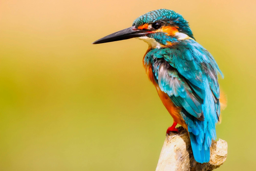

In [14]:
im = Image.open('data/bird.jpg')
im.to_thumb(256,256)

In [ ]:
print(probs)